<a href="https://colab.research.google.com/github/leake1617/Ge-ez/blob/main/Meta_Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install transformers torch torchvision pillow
!pip install jiwer pandas matplotlib seaborn
!pip install requests opencv-python-headless

# 2. Import libraries
import os, json, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
from google.colab import drive
from jiwer import cer, wer

# 3. Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using: {device}")

# 4. Load FREE Meta TrOCR model
print("Loading Meta TrOCR model...")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed").to(device)
print("✅ Model loaded - NO COST!")

# 5. Mount Google Drive
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Meta_OCR_Analysis"
os.makedirs(f"{project_path}/images", exist_ok=True)
os.makedirs(f"{project_path}/ground_truth", exist_ok=True)
os.makedirs(f"{project_path}/results", exist_ok=True)
print("✅ Project setup complete!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.7 MB/s eta 0:00:00
🚀 Using: cuda
Loading Meta TrOCR model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded - NO COST!
Mounted at /content/drive
✅ Project setup complete!


In [6]:
from google.colab import files
import os
import shutil

print("📤 Step 1: Upload IMAGE files (PNG, JPG, etc.):")
uploaded_images = files.upload()
for filename in uploaded_images.keys():
    shutil.move(filename, f"{project_path}/images/{filename}")

print("📤 Step 2: Upload GROUND TRUTH text files:")
uploaded_truth = files.upload()
for filename in uploaded_truth.keys():
    shutil.move(filename, f"{project_path}/ground_truth/{filename}")

print("Images:", os.listdir(f"{project_path}/images"))
print("Ground truth:", os.listdir(f"{project_path}/ground_truth"))


📤 Step 1: Upload IMAGE files (PNG, JPG, etc.):


Saving page_17.png to page_17 (1).png
Saving page_18.png to page_18 (1).png
Saving page_19.png to page_19 (1).png
Saving page_20.png to page_20 (1).png
Saving page_21.png to page_21 (1).png
Saving page_22.png to page_22 (1).png
Saving page_23.png to page_23 (1).png
Saving page_24.png to page_24 (1).png
Saving page_25.png to page_25 (1).png
Saving page_26.png to page_26 (1).png
Saving page_27.png to page_27 (1).png
📤 Step 2: Upload GROUND TRUTH text files:


Saving page_17.txt to page_17.txt
Saving page_18.txt to page_18.txt
Saving page_19.txt to page_19.txt
Saving page_20.txt to page_20.txt
Saving page_21.txt to page_21.txt
Saving page_22.txt to page_22.txt
Saving page_23.txt to page_23.txt
Saving page_24.txt to page_24.txt
Saving page_25.txt to page_25.txt
Saving page_26.txt to page_26.txt
Saving page_27.txt to page_27.txt
Images: ['page_17 (1).png', 'page_18 (1).png', 'page_19 (1).png', 'page_20 (1).png', 'page_21 (1).png', 'page_22 (1).png', 'page_23 (1).png', 'page_24 (1).png', 'page_25 (1).png', 'page_26 (1).png', 'page_27 (1).png']
Ground truth: ['page_17.txt', 'page_18.txt', 'page_19.txt', 'page_20.txt', 'page_21.txt', 'page_22.txt', 'page_23.txt', 'page_24.txt', 'page_25.txt', 'page_26.txt', 'page_27.txt']


In [7]:
import os

img_dir = f"{project_path}/images"

for filename in os.listdir(img_dir):
    if " (1)" in filename:
        new_name = filename.replace(" (1)", "")
        os.rename(os.path.join(img_dir, filename),
                  os.path.join(img_dir, new_name))

print("✅ Renamed files:")
print(os.listdir(img_dir))


✅ Renamed files:
['page_17.png', 'page_18.png', 'page_19.png', 'page_20.png', 'page_21.png', 'page_22.png', 'page_23.png', 'page_24.png', 'page_25.png', 'page_26.png', 'page_27.png']


In [9]:
# Run the analysis
def analyze_images():
    images_dir = f"{project_path}/images"
    truth_dir = f"{project_path}/ground_truth"

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"🔍 Analyzing {len(image_files)} images...")

    results = []
    for i, image_file in enumerate(image_files):
        print(f"Processing {i+1}/{len(image_files)}: {image_file}")

        # Paths
        image_path = os.path.join(images_dir, image_file)
        base_name = os.path.splitext(image_file)[0]
        truth_path = os.path.join(truth_dir, f"{base_name}.txt")

        # Skip if no ground truth
        if not os.path.exists(truth_path):
            continue

        # Read ground truth
        with open(truth_path, 'r', encoding='utf-8') as f:
            ground_truth = f.read().strip()

        # Run Meta OCR
        try:
            image = Image.open(image_path).convert('RGB')
            pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
            generated_ids = model.generate(pixel_values)
            extracted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            # Calculate metrics
            cer_score = cer(ground_truth, extracted_text)
            wer_score = wer(ground_truth, extracted_text)

            results.append({
                'image': image_file,
                'ground_truth': ground_truth,
                'extracted_text': extracted_text,
                'cer': cer_score,
                'wer': wer_score
            })

            print(f"   ✅ CER: {cer_score:.4f}, WER: {wer_score:.4f}")

        except Exception as e:
            print(f"   ❌ Error: {str(e)}")

    return results

# Execute analysis
print("Starting OCR analysis...")
results = analyze_images()
print("🎉 Analysis complete!")


Starting OCR analysis...
🔍 Analyzing 11 images...
Processing 1/11: page_17.png
   ✅ CER: 0.9975, WER: 1.0000
Processing 2/11: page_18.png
   ✅ CER: 0.9979, WER: 1.0000
Processing 3/11: page_19.png
   ✅ CER: 0.9995, WER: 1.0000
Processing 4/11: page_20.png
   ✅ CER: 1.0000, WER: 1.0000
Processing 5/11: page_21.png
   ✅ CER: 1.0000, WER: 1.0000
Processing 6/11: page_22.png
   ✅ CER: 0.9984, WER: 1.0000
Processing 7/11: page_23.png
   ✅ CER: 0.9984, WER: 1.0000
Processing 8/11: page_24.png
   ✅ CER: 1.0000, WER: 1.0000
Processing 9/11: page_25.png
   ✅ CER: 0.9995, WER: 1.0000
Processing 10/11: page_26.png
   ✅ CER: 1.0000, WER: 1.0000
Processing 11/11: page_27.png
   ✅ CER: 1.0000, WER: 1.0000
🎉 Analysis complete!



📊 RESULTS SUMMARY:
Total images processed: 11
Average CER: 0.9992
Average WER: 1.0000
Total cost: $0.00 🎉

Top 5 results:
         image       cer  wer
0  page_17.png  0.997539  1.0
1  page_18.png  0.997926  1.0
2  page_19.png  0.999506  1.0
3  page_20.png  1.000000  1.0
4  page_21.png  1.000000  1.0

💾 Results saved to: /content/drive/MyDrive/Meta_OCR_Analysis/results/meta_ocr_results.csv


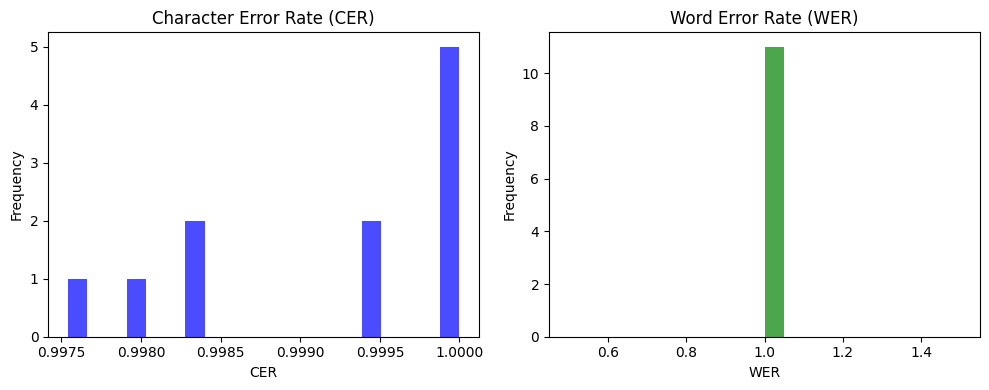

In [10]:
# Create results dataframe
df = pd.DataFrame(results)

# Display summary
print("\n📊 RESULTS SUMMARY:")
print(f"Total images processed: {len(df)}")
print(f"Average CER: {df['cer'].mean():.4f}")
print(f"Average WER: {df['wer'].mean():.4f}")
print(f"Total cost: $0.00 🎉")

# Show top 5 results
print("\nTop 5 results:")
print(df[['image', 'cer', 'wer']].head())

# Save to Google Drive
results_path = f"{project_path}/results/meta_ocr_results.csv"
df.to_csv(results_path, index=False, encoding='utf-8')
print(f"\n💾 Results saved to: {results_path}")

# Create simple visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['cer'], bins=20, alpha=0.7, color='blue')
plt.title('Character Error Rate (CER)')
plt.xlabel('CER')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['wer'], bins=20, alpha=0.7, color='green')
plt.title('Word Error Rate (WER)')
plt.xlabel('WER')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Welcome to this Colab where you will get a quick introduction to the Python programming language and the environment used for the course's exercises: Colab.

Colab is a Python development environment that runs in the browser using Google Cloud.

For example, to print "Hello World", just hover the mouse over [ ] and press the play button to the upper left. Or press shift-enter to execute.

In [ ]:
print("Hello World")

## Functions, Conditionals, and Iteration
Let's create a Python function, and call it from a loop.

In [ ]:
def HelloWorldXY(x, y):
  if (x < 10):
    print("Hello World, x was < 10")
  elif (x < 20):
    print("Hello World, x was >= 10 but < 20")
  else:
    print("Hello World, x was >= 20")
  return x + y

for i in range(8, 25, 5):  # i=8, 13, 18, 23 (start, stop, step)
  print("--- Now running with i: {}".format(i))
  r = HelloWorldXY(i,i)
  print("Result from HelloWorld: {}".format(r))

In [ ]:
print(HelloWorldXY(1,2))

Easy, right?

If you want a loop starting at 0 to 2 (exclusive) you could do any of the following

In [ ]:
print("Iterate over the items. `range(2)` is like a list [0,1].")
for i in range(2):
  print(i)

print("Iterate over an actual list.")
for i in [0,1]:
  print(i)

print("While works")
i = 0
while i < 2:
  print(i)
  i += 1

In [ ]:
print("Python supports standard key words like continue and break")
while True:
  print("Entered while")
  break

## Numpy and lists
Python has lists built into the language.
However, we will use a library called numpy for this.
Numpy gives you lots of support functions that are useful when doing Machine Learning.

Here, you will also see an import statement. This statement makes the entire numpy package available and we can access those symbols using the abbreviated 'np' syntax.

In [ ]:
import numpy as np  # Make numpy available using np.

# Create a numpy array, and append an element
a = np.array(["Hello", "World"])
a = np.append(a, "!")
print("Current array: {}".format(a))
print("Printing each element")
for i in a:
  print(i)

print("\nPrinting each element and their index")
for i,e in enumerate(a):
  print("Index: {}, was: {}".format(i, e))

In [ ]:
print("\nShowing some basic math on arrays")
b = np.array([0,1,4,3,2])
print("Max: {}".format(np.max(b)))
print("Average: {}".format(np.average(b)))
print("Max index: {}".format(np.argmax(b)))

In [ ]:
print("\nYou can print the type of anything")
print("Type of b: {}, type of b[0]: {}".format(type(b), type(b[0])))

In [ ]:
print("\nUse numpy to create a [3,3] dimension array with random number")
c = np.random.rand(3, 3)
print(c)

In [ ]:
print("\nYou can print the dimensions of arrays")
print("Shape of a: {}".format(a.shape))
print("Shape of b: {}".format(b.shape))
print("Shape of c: {}".format(c.shape))
print("...Observe, Python uses both [0,1,2] and (0,1,2) to specify lists")

## Colab Specifics

Colab is a virtual machine you can access directly. To run commands at the VM's terminal, prefix the line with an exclamation point (!).


In [ ]:
print("\nDoing $ls on filesystem")
!ls -l
!pwd

In [ ]:
print("Install numpy")  # Just for test, numpy is actually preinstalled in all Colab instances
!pip install numpy

**Exercise**

Create a code cell underneath this text cell and add code to:


*   List the path of the current directory (pwd)
* Go to / (cd) and list the content (ls -l)

In [ ]:
!pwd
!cd /
!ls -l
print("Hello")

All usage of Colab in this course is completely free or charge. Even GPU usage is provided free of charge for some hours of usage every day.

**Using GPUs**
* Many of the exercises in the course executes more quickly by using GPU runtime: Runtime | Change runtime type | Hardware accelerator | GPU

**Some final words on Colab**
*   You execute each cell in order, you can edit & re-execute cells if you want
*   Sometimes, this could have unintended consequences. For example, if you add a dimension to an array and execute the cell multiple times, then the cells after may not work. If you encounter problem reset your environment:
  *   Runtime -> Restart runtime... Resets your Python shell
  *   Runtime -> Restart all runtimes... Will reset the Colab image, and get you back to a 100% clean environment
* You can also clear the output in the Colab by doing: Edit -> Clear all outputs
* Colabs in this course are loaded from GitHub. Save to your Google Drive if you want a copy with your code/output: File -> Save a copy in Drive...

**Learn More**
*   Check out [this](https://www.youtube.com/watch?v=inN8seMm7UI&list=PLQY2H8rRoyvwLbzbnKJ59NkZvQAW9wLbx&index=3) episode of #CodingTensorFlow, and don't forget to subscribe to the YouTube channel ;)
